In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import sys
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
import os

## Multilayer CNN

Couche de poids paramétrable

In [4]:
def weight_variable(shape, stddev = 0.1, name = "dummy"):
    #initial = tf.truncated_normal(shape, stddev=0.1)
    initial = tf.random_normal(shape, stddev)
    #initial = tf.zeros(shape)
    return tf.Variable(initial, name = name)

Construction d'un operateur de convolution

(la taille de la fenetre de convolution est donnée par W)

In [5]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 2, 2, 1], padding='VALID')

convertisseur image 32 x 32

In [6]:
def mnist_reshape_32(x_batch):
    if len(x_batch.shape) > 1 :
        m, _ = x_batch.shape
        batch32 = np.zeros((m, 1024))
        for i, x in enumerate(x_batch):
            assert x.shape == (28 * 28,)
            image = x.reshape(28, 28)
            image = np.append(np.zeros((2, 28)), image, axis = 0)
            image = np.append(image, np.zeros((2, 28)), axis = 0)
            image = np.append(np.zeros((32, 2)), image, axis = 1)
            image = np.append(image, np.zeros((32, 2)), axis = 1)
            batch32[i,:] = image.reshape((32 * 32,))
    else:
        m = x_batch.shape
        batch32 = np.zeros((1024,))
        assert x_batch.shape == (28 * 28,)
        image = x_batch.reshape(28, 28)
        image = np.append(np.zeros((2, 28)), image, axis = 0)
        image = np.append(image, np.zeros((2, 28)), axis = 0)
        image = np.append(np.zeros((32, 2)), image, axis = 1)
        image = np.append(image, np.zeros((32, 2)), axis = 1)
        batch32 = image.reshape((1,32 * 32))
    return batch32 #.tolist()

## Prediction graph

Construction couche 1 : 32 x 32 --> 16 x 16

In [7]:
DEPTH1 = 8
WIDTH1 = 4
OUT1 = 32 / WIDTH1

DEPTH2 = 32
WIDTH2 = 4
OUT2 = 32 / WIDTH1 / WIDTH2

DEPTH3 = 128
WIDTH3 = 2
OUT3 = 32 / WIDTH1 / WIDTH2 / WIDTH3


#DEPTH4 = 512

#DEPTH1 = 8
#DEPTH2 = 16
#DEPTH3 = 32
#DEPTH4 = 64

STD = 1.

BATCH_SIZE = 50


TensorFlow session

Data placeholders

(les données sont empilées selon dimension 0)

In [8]:
sess = tf.InteractiveSession()

Data placeholders

(les données sont empilées selon dimension 0)

In [9]:
x = tf.placeholder(tf.float32, shape=[None, 1024])
y_ = tf.placeholder(tf.float32, shape=[None, 10])
training_step = tf.placeholder(tf.float32, shape=[3])

In [10]:
# Paramètres
W_conv1 = weight_variable([WIDTH1, WIDTH1, 1, DEPTH1], stddev = STD / (WIDTH1 * WIDTH1), name = "W_conv1")
# Input 2D reshape
x_image = tf.reshape(x, [-1, 32, 32, 1])
# Graph construction
h_conv1 = tf.nn.conv2d(x_image, W_conv1, strides=[1, WIDTH1, WIDTH1, 1], padding='VALID') 
#z_conv1 = tf.nn.relu(h_conv1)
z_conv1 = tf.nn.softmax(h_conv1)

W_conv2 = weight_variable([WIDTH2, WIDTH2, DEPTH1, DEPTH2], stddev = STD / (WIDTH2 * WIDTH2 * DEPTH1), name = "W_conv2")
h_conv2 = tf.nn.conv2d(z_conv1, W_conv2, strides=[1, WIDTH2, WIDTH2, 1], padding='VALID') 
z_conv2 = tf.nn.softmax(h_conv2)

W_conv3 = weight_variable([WIDTH3, WIDTH3, DEPTH2, DEPTH3], stddev = STD / (WIDTH3 * WIDTH3 * DEPTH2), name = "W_conv3")
h_conv3 = tf.nn.conv2d(z_conv2, W_conv3, strides=[1, WIDTH3, WIDTH3, 1], padding='VALID') 
z_conv3 = tf.nn.softmax(h_conv3)


### Generative graph
  - incremental learning
  - ladder structure

In [11]:

W_deconv2 = weight_variable([WIDTH3, WIDTH3, DEPTH2, DEPTH3], stddev = STD / (WIDTH3 * WIDTH3 * DEPTH2), name = "W_deconv2")
z_in2 = tf.scalar_mul(training_step[2], z_conv3) 
h_deconv2 = tf.nn.conv2d_transpose(z_in2, W_deconv2, output_shape=[BATCH_SIZE, OUT2, OUT2, DEPTH2],
                                        strides=[1, WIDTH3, WIDTH3, 1], padding='VALID') 
z_deconv2 = tf.nn.softmax(h_deconv2)

W_deconv1 = weight_variable([WIDTH2, WIDTH2, DEPTH1, DEPTH2], stddev = STD / (WIDTH2 * WIDTH2 * DEPTH1), name = "W_deconv1")
z_in1 =   tf.scalar_mul(training_step[1], z_conv2  ) \
        + tf.scalar_mul(training_step[2], z_deconv2)
h_deconv1 = tf.nn.conv2d_transpose(z_in1, W_deconv1, output_shape=[BATCH_SIZE, OUT1, OUT1, DEPTH1],
                                        strides=[1, WIDTH2, WIDTH2, 1], padding='VALID') 
z_deconv1 = tf.nn.softmax(h_deconv1)

W_deconv0 = weight_variable([WIDTH1, WIDTH1, 1, DEPTH1], stddev = STD / (WIDTH1 * WIDTH1), name = "W_deconv0")
z_in0 =   tf.scalar_mul( training_step[0]     , z_conv1  ) \
        + tf.scalar_mul( 1 - ((1 - training_step[1]) * (1 - training_step[2])) , z_deconv1)
h_deconv0 = tf.nn.conv2d_transpose(z_in0, W_deconv0, output_shape=[BATCH_SIZE, 32, 32, 1],
                                        strides=[1, WIDTH1, WIDTH1, 1], padding='VALID') 
x_deconv0 = tf.nn.sigmoid(h_deconv0)
x_out = tf.reshape(x_deconv0, [-1, 32 * 32])



### Readout graph

In [12]:
z_flat1 = tf.reshape(z_conv1, [-1, OUT1 * OUT1 * DEPTH1])
z_flat2 = tf.reshape(z_conv2, [-1, OUT2 * OUT2 * DEPTH2])
z_flat3 = tf.reshape(z_conv3, [-1, OUT3 * OUT3 * DEPTH3])

W_out1 = weight_variable([OUT1 * OUT1 * DEPTH1, 10], stddev = STD / (OUT1 * OUT1 * DEPTH1), name = "W_out1")
W_out2 = weight_variable([OUT2 * OUT2 * DEPTH2, 10], stddev = STD / (OUT2 * OUT2 * DEPTH2), name = "W_out2")
W_out3 = weight_variable([OUT3 * OUT3 * DEPTH3, 10], stddev = STD / (OUT3 * OUT3 * DEPTH3), name = "W_out3")


y_cnn =   tf.scalar_mul(training_step[0], tf.matmul(z_flat1, W_out1)) \
        + tf.scalar_mul(training_step[1], tf.matmul(z_flat2, W_out2)) \
        + tf.scalar_mul(training_step[2], tf.matmul(z_flat3, W_out3)) 


## Loss graph

In [13]:
classif_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_cnn))
#beta = 0
#cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_cnn)\
#                               + beta * (tf.nn.l2_loss(W_conv1) \
#                                      + tf.nn.l2_loss(W_conv2) \
#                                      + tf.nn.l2_loss(W_out)))

gen_loss1 = tf.reduce_mean(tf.square(x - x_out))
gen_loss2 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=z_conv1, logits=h_deconv1))
#tf.reduce_mean(tf.square(z_conv1 - z_deconv1))
#gen_loss2 = tf.reduce_mean(tf.square(z_conv2 - z_deconv2))
gen_loss3 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=z_conv2, logits=h_deconv2))

gen_loss = tf.reduce_mean(tf.square(x - x_out))


## Train graph

In [14]:
classif_train_stage1 = tf.train.AdamOptimizer(3e-5).minimize(classif_loss, var_list = [W_conv1, W_out1])
classif_train_stage2 = tf.train.AdamOptimizer(1e-4).minimize(classif_loss, var_list = [W_conv1, W_conv2, W_out2])
classif_train_stage3 = tf.train.AdamOptimizer(1e-4).minimize(classif_loss, var_list = [W_conv1, W_conv2, W_conv3, W_out3])

gen_train_stage1 = tf.train.AdamOptimizer(1e-4).minimize(gen_loss , var_list = [W_deconv0, W_conv1])
gen_train_stage2 = tf.train.AdamOptimizer(1e-4).minimize(gen_loss , var_list = [W_deconv0, W_deconv1, W_conv1, W_conv2])
gen_train_stage3 = tf.train.AdamOptimizer(3e-5).minimize(gen_loss , var_list = [W_deconv0, W_deconv1, W_deconv2, W_conv1, W_conv2, W_conv3])
#gen_train_step = tf.train.AdamOptimizer(1e-4).minimize(gen_loss , var_list = [W_deconv1, b_deconv1, W_deconv0, b_deconv0])


# train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

## Evaluation graph

In [15]:
correct_prediction = tf.equal(tf.argmax(y_cnn, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
gen_accuracy = tf.sqrt(tf.reduce_mean(tf.square(x - x_out)))

## Training

In [16]:
turn = 1
if turn ==1:
    sess.run(tf.global_variables_initializer())

In [17]:
saver = tf.train.Saver()

### Train session 1

In [18]:
#with tf.Session() as sess:
if not os.path.isfile("models/deep-MNIST-3-couches-incremental-optim-sans-biais-STAGE1-turn2.ckpt.index"):
    for rep in range(10):
        for i in range(20000): 
            batch = mnist.train.next_batch(BATCH_SIZE)
            if i % 10 == 0:
                train_accuracy     = accuracy.eval(   feed_dict={x: mnist_reshape_32(batch[0]),\
                                                                 y_: batch[1],\
                                                                 training_step : [1, 0, 0]})
                train_gen_accuracy = gen_accuracy.eval(feed_dict={x: mnist_reshape_32(batch[0]),\
                                                                  y_: batch[1],\
                                                                  training_step : [1, 0, 0]})
                sys.stdout.write('\rstep %d, training accuracy : %.2f, generative avg error : %.4f' % (i + rep * 20000, \
                                                                                                       train_accuracy, \
                                                                                                       train_gen_accuracy))
                sys.stdout.flush()
            classif_train_stage1.run(feed_dict={x: mnist_reshape_32(batch[0]),\
                                               y_: batch[1],\
                                               training_step : [1, 0, 0]})
            gen_train_stage1.run(feed_dict={x: mnist_reshape_32(batch[0]),\
                                           training_step : [1, 0, 0]})
        saver.save(sess, "models/deep-MNIST-3-couches-incremental-optim-sans-biais-STAGE1-turn2.ckpt")
else:
    saver.restore(sess,'models/deep-MNIST-3-couches-incremental-optim-sans-biais-STAGE1-turn2.ckpt')


INFO:tensorflow:Restoring parameters from models/deep-MNIST-3-couches-incremental-optim-sans-biais-STAGE1-turn2.ckpt


**Notes** :
  - Avec connectivité totale des couches forward et bakward (ladder connectivity --> effet de regularisation)
  - Connectivité selon training_step (app incremental)--> l'erreur de reconstruction stagne à 0.1
  - Connectivité selon training_step (app incremental) avec back-prop sur les liens entrants (discriminatifs)
    --> l'erreur de reconstruction descend à 0.06

In [19]:
print('test accuracy %g' % accuracy.eval(feed_dict={x: mnist_reshape_32(mnist.test.images),\
                                                    y_: mnist.test.labels,\
                                                    training_step : [1, 0, 0]}))
print('test generative accuracy %g' % gen_accuracy.eval(feed_dict={x: mnist_reshape_32(mnist.test.images)[:50,:],\
                                                                   y_: mnist.test.labels[:50,:],\
                                                                   training_step : [1, 0, 0]}))

test accuracy 0.8958
test generative accuracy 0.0482518


### Tests

In [20]:
batch = mnist.test.next_batch(BATCH_SIZE) 

(1, 8, 8, 8)
(1, 2, 2, 32)
(1, 1, 1, 128)
(1, 10)


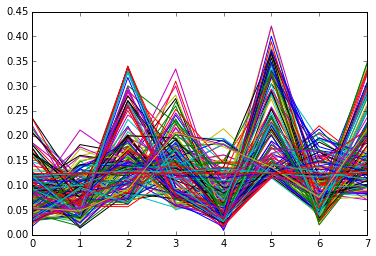

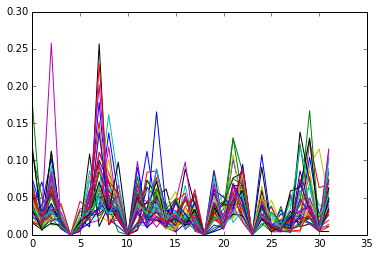

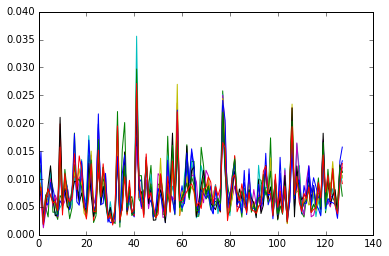

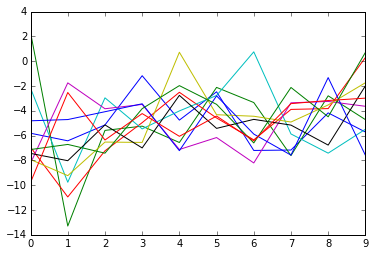

In [21]:
training_step_test = [1, 0, 0]
test = sess.run(z_conv1, {x: mnist_reshape_32(batch[0][0]), training_step : training_step_test})
print test.shape
figure()
for k in range(10):        
    test = sess.run(z_conv1, {x: mnist_reshape_32(batch[0][k]), training_step : training_step_test})
    for i in range(OUT1):
        for j in range(OUT1):
            plot(test[0,i,j,:])

test = sess.run(z_conv2, {x: mnist_reshape_32(batch[0][0]), training_step : training_step_test})
print test.shape
figure()
for k in range(10):        
    test = sess.run(z_conv2, {x: mnist_reshape_32(batch[0][k]), training_step : training_step_test})
    for i in range(OUT2):
        for j in range(OUT2):
            plot(test[0,i,j,:])

test = sess.run(z_conv3, {x: mnist_reshape_32(batch[0][0]), training_step : training_step_test})
print test.shape
figure()
for k in range(10):        
    test = sess.run(z_conv3, {x: mnist_reshape_32(batch[0][k]), training_step : training_step_test})
    for i in range(OUT3):
        for j in range(OUT3):
            plot(test[0,i,j,:])

test = sess.run(y_cnn, {x: mnist_reshape_32(batch[0][0]), training_step : training_step_test})
print test.shape
figure()
for k in range(10):        
    test = sess.run(y_cnn, {x: mnist_reshape_32(batch[0][k]), training_step : training_step_test})
    plot(test[0])


[3]
[0]
[9]
[6]
[1]
[4]
[9]
[8]
[9]
[1]


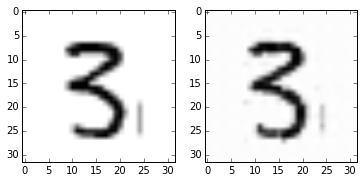

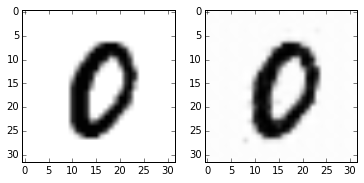

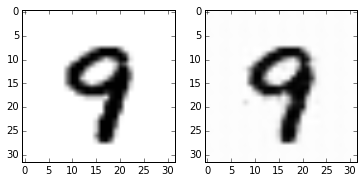

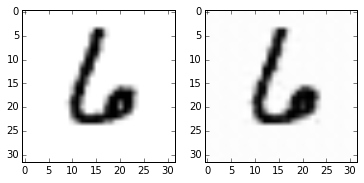

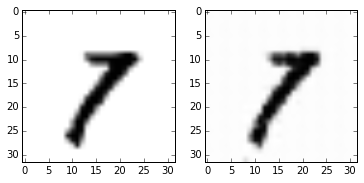

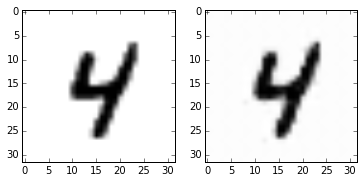

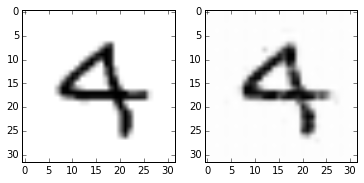

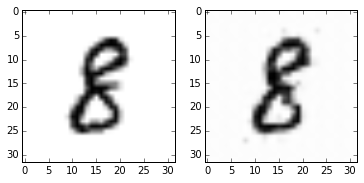

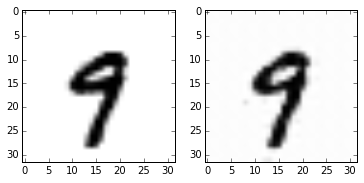

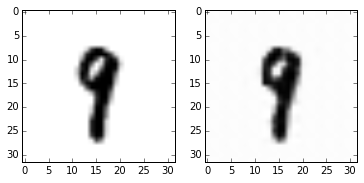

In [22]:
training_step_test = [1, 0, 0]
for k in range(10):
    figure()
    subplot(1,2,1)
    imshow(mnist_reshape_32(batch[0][k,:]).reshape((32,32)), cmap = 'gray_r')
    subplot(1,2,2)
    imshow(x_out.eval(feed_dict={x: mnist_reshape_32(batch[0]), training_step : training_step_test})[k,:].reshape((32,32)), cmap = 'gray_r')
    print(tf.argmax(y_cnn, 1).eval(feed_dict={x: mnist_reshape_32(batch[0][k]), training_step : training_step_test}))

(4, 4, 1, 8)


/usr/lib/python2.7/dist-packages/matplotlib/axes/_subplots.py:69: MatplotlibDeprecationWarning: The use of 0 (which ends up being the _last_ sub-plot) is deprecated in 1.4 and will raise an error in 1.5
  mplDeprecation)


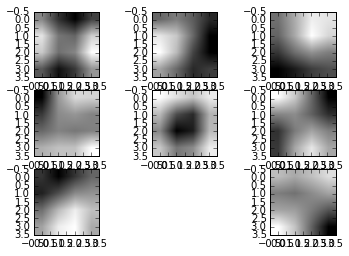

In [23]:
print W_deconv0.eval().shape

for i in range(8):
    subplot(3,3,i)
    imshow(W_deconv0.eval()[:,:,0,i].reshape((4,4)), cmap = 'gray_r')

In [24]:
print OUT1, OUT1, DEPTH1
print OUT2, OUT2, DEPTH2
print OUT3, OUT3, DEPTH3

8 8 8
2 2 32
1 1 128


# Train session 2

In [25]:
if not os.path.isfile("models/deep-MNIST-3-couches-incremental-optim-sans-biais-STAGE2-turn2.ckpt.index"):
    for rep in range(10): #60
        for i in range(20000): #1200000
            batch = mnist.train.next_batch(BATCH_SIZE)
            if i % 10 == 0:
                train_accuracy     = accuracy.eval(    feed_dict = {x: mnist_reshape_32(batch[0]),\
                                                                    y_: batch[1],\
                                                                    training_step : [0, 1, 0]})
                train_gen_accuracy = gen_accuracy.eval(feed_dict = {x: mnist_reshape_32(batch[0]),\
                                                                    y_: batch[1],\
                                                                    training_step : [0, 1, 0]}) 
                sys.stdout.write('\rstep %d, training accuracy : %.2f, generative avg error : %.4f' % (i + rep * 20000, \
                                                                                                       train_accuracy, \
                                                                                                       train_gen_accuracy))
                sys.stdout.flush()
            classif_train_stage2.run(feed_dict={x: mnist_reshape_32(batch[0]),\
                                               y_: batch[1],\
                                               training_step : [0, 1, 0]}) 
            gen_train_stage2.run(feed_dict={x: mnist_reshape_32(batch[0]),\
                                           training_step : [0, 1, 0]}) 
        saver.save(sess, "models/deep-MNIST-3-couches-incremental-optim-sans-biais-STAGE2-turn2.ckpt")
else :
    saver.restore(sess,'models/deep-MNIST-3-couches-incremental-optim-sans-biais-STAGE2-turn2.ckpt')


INFO:tensorflow:Restoring parameters from models/deep-MNIST-3-couches-incremental-optim-sans-biais-STAGE2-turn2.ckpt


if not os.path.isfile("deep-MNIST-3-couches-incremental-discr.3-sans-biais-HALF-FULL.ckpt.index"):
    for rep in range(60):
        for i in range(20000): #1200000
            batch = mnist.train.next_batch(BATCH_SIZE)
            if i % 10 == 0:
                train_accuracy     = accuracy.eval(    feed_dict = {x: mnist_reshape_32(batch[0]),\
                                                                    y_: batch[1],\
                                                                    training_step : [0, 1, 1]})
                train_gen_accuracy = gen_accuracy.eval(feed_dict = {x: mnist_reshape_32(batch[0]),\
                                                                    y_: batch[1],\
                                                                    training_step : [0, 1, 1]}) 
                sys.stdout.write('\rstep %d, training accuracy : %.2f, generative avg error : %.4f' % (i + rep * 20000, \
                                                                                                       train_accuracy, \
                                                                                                       train_gen_accuracy))
                sys.stdout.flush()
            classif_train_stage3.run(feed_dict={x: mnist_reshape_32(batch[0]),\
                                               y_: batch[1],\
                                               training_step : [0, 1, 1]}) 
            gen_train_stage3.run(feed_dict={x: mnist_reshape_32(batch[0]),\
                                           training_step : [0, 1, 1]}) 
        saver.save(sess, "deep-MNIST-3-couches-incremental-discr.3-sans-biais-HALF-FULL.ckpt")
else :
    saver.restore(sess,'deep-MNIST-3-couches-incremental-discr.3-sans-biais-HALF-FULL.ckpt')


In [26]:
print('test accuracy %g' % accuracy.eval(feed_dict={x: mnist_reshape_32(mnist.test.images),\
                                                    y_: mnist.test.labels,\
                                                    training_step : [0, 1, 0]}))
print('test generative accuracy %g' % gen_accuracy.eval(feed_dict={x: mnist_reshape_32(mnist.test.images)[:50,:],\
                                                                   y_: mnist.test.labels[:50,:],\
                                                                   training_step : [0, 1, 0]}))

test accuracy 0.9437
test generative accuracy 0.0813878


In [27]:
batch = mnist.test.next_batch(BATCH_SIZE) 

(1, 8, 8, 8)
(1, 2, 2, 32)
(1, 1, 1, 128)
(1, 10)


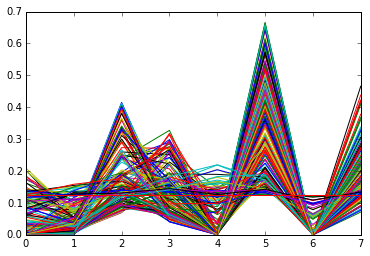

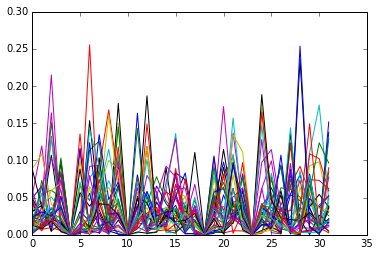

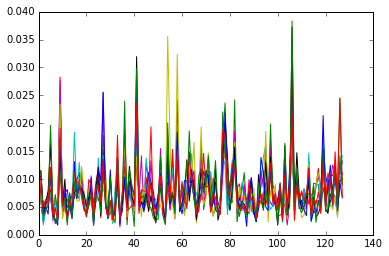

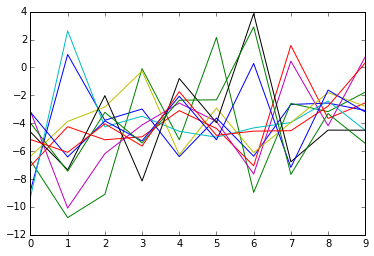

In [28]:
training_step_test = [0, 1, 0]
test = sess.run(z_conv1, {x: mnist_reshape_32(batch[0][0]), training_step : training_step_test})
print test.shape
figure()
for k in range(10):        
    test = sess.run(z_conv1, {x: mnist_reshape_32(batch[0][k]), training_step : training_step_test})
    for i in range(OUT1):
        for j in range(OUT1):
            plot(test[0,i,j,:])

test = sess.run(z_conv2, {x: mnist_reshape_32(batch[0][0]), training_step : training_step_test})
print test.shape
figure()
for k in range(10):        
    test = sess.run(z_conv2, {x: mnist_reshape_32(batch[0][k]), training_step : training_step_test})
    for i in range(OUT2):
        for j in range(OUT2):
            plot(test[0,i,j,:])

test = sess.run(z_conv3, {x: mnist_reshape_32(batch[0][0]), training_step : training_step_test})
print test.shape
figure()
for k in range(10):        
    test = sess.run(z_conv3, {x: mnist_reshape_32(batch[0][k]), training_step : training_step_test})
    for i in range(OUT3):
        for j in range(OUT3):
            plot(test[0,i,j,:])

test = sess.run(y_cnn, {x: mnist_reshape_32(batch[0][0]), training_step : training_step_test})
print test.shape
figure()
for k in range(10):        
    test = sess.run(y_cnn, {x: mnist_reshape_32(batch[0][k]), training_step : training_step_test})
    plot(test[0])


Représentation intermédiaire (quart d'image) --> chaque quart est un "bout d'image"

[1]
[5]
[7]
[1]
[9]
[3]
[6]
[6]
[6]
[9]


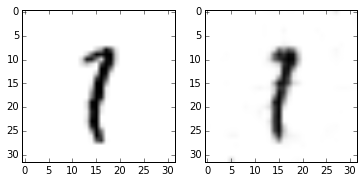

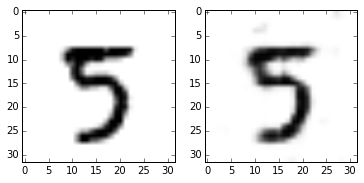

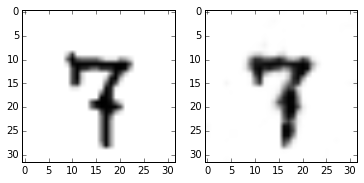

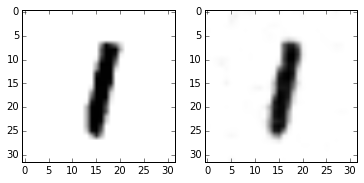

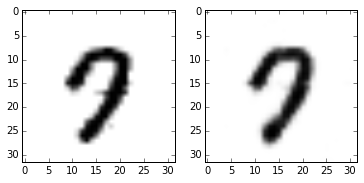

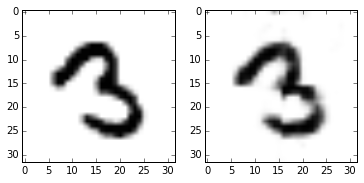

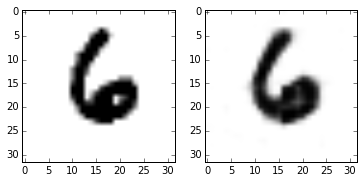

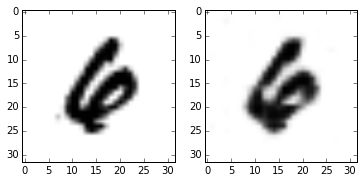

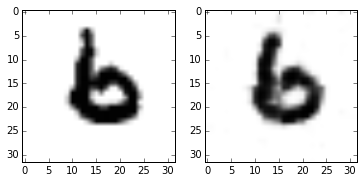

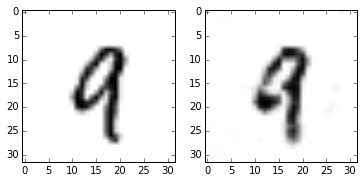

In [29]:
training_step_test = [0, 1, 0]
for k in range(10):
    figure()
    subplot(1,2,1)
    imshow(mnist_reshape_32(batch[0][k,:]).reshape((32,32)), cmap = 'gray_r')
    subplot(1,2,2)
    imshow(x_out.eval(feed_dict={x: mnist_reshape_32(batch[0]), training_step : training_step_test})[k,:].reshape((32,32)), cmap = 'gray_r')
    print(tf.argmax(y_cnn, 1).eval(feed_dict={x: mnist_reshape_32(batch[0][k]), training_step : training_step_test}))

## Train session 3

In [19]:
#with tf.Session() as sess:
if not os.path.isfile("models/deep-MNIST-3-couches-incremental-optim-sans-biais-INTERLEAVED-test2.ckpt.index"):
    for rep in range(60): #120
        for i in range(20000): #2400000
            batch = mnist.train.next_batch(BATCH_SIZE)
            if i % 10 == 0:
                train_accuracy     = accuracy.eval(    feed_dict = {x: mnist_reshape_32(batch[0]),\
                                                                    y_: batch[1],\
                                                                    training_step : [0, 0, 1]})
                train_gen_accuracy = gen_accuracy.eval(feed_dict = {x: mnist_reshape_32(batch[0]),\
                                                                    y_: batch[1],\
                                                                    training_step : [0, 0, 1]}) 
                sys.stdout.write('\rstep %d, training accuracy : %.2f, generative avg error : %.4f' % (i + rep * 20000, \
                                                                                                       train_accuracy, \
                                                                                                       train_gen_accuracy))
                sys.stdout.flush()
            if i % 3 == 0:    
                classif_train_stage1.run(feed_dict={x: mnist_reshape_32(batch[0]),\
                                                   y_: batch[1],\
                                                   training_step : [1, 0, 0]}) 
                gen_train_stage1.run(feed_dict={x: mnist_reshape_32(batch[0]),\
                                               training_step : [1, 0, 0]}) 
            elif i % 3 == 1:
                classif_train_stage2.run(feed_dict={x: mnist_reshape_32(batch[0]),\
                                                   y_: batch[1],\
                                                   training_step : [0, 1, 0]}) 
                gen_train_stage2.run(feed_dict={x: mnist_reshape_32(batch[0]),\
                                               training_step : [0, 1, 0]}) 
            else:
                classif_train_stage3.run(feed_dict={x: mnist_reshape_32(batch[0]),\
                                                   y_: batch[1],\
                                                   training_step : [0, 0, 1]}) 
                gen_train_stage3.run(feed_dict={x: mnist_reshape_32(batch[0]),\
                                               training_step : [0, 0, 1]}) 
        saver.save(sess, "models/deep-MNIST-3-couches-incremental-optim-sans-biais-INTERLEAVED-test.ckpt")
else:
    saver.restore(sess,'models/deep-MNIST-3-couches-incremental-optim-sans-biais-INTERLEAVED-test.ckpt')


step 1199990, training accuracy : 0.94, generative avg error : 0.1335

#with tf.Session() as sess:
if not os.path.isfile("models/deep-MNIST-3-couches-incremental-optim-sans-biais-STAGE3-turn3.ckpt.index"):
    for rep in range(10): #120
        for i in range(20000): #2400000
            batch = mnist.train.next_batch(BATCH_SIZE)
            if i % 10 == 0:
                train_accuracy     = accuracy.eval(    feed_dict = {x: mnist_reshape_32(batch[0]),\
                                                                    y_: batch[1],\
                                                                    training_step : [0, 0, 1]})
                train_gen_accuracy = gen_accuracy.eval(feed_dict = {x: mnist_reshape_32(batch[0]),\
                                                                    y_: batch[1],\
                                                                    training_step : [0, 0, 1]}) 
                sys.stdout.write('\rstep %d, training accuracy : %.2f, generative avg error : %.4f' % (i + rep * 20000, \
                                                                                                       train_accuracy, \
                                                                                                       train_gen_accuracy))
                sys.stdout.flush()
            classif_train_stage3.run(feed_dict={x: mnist_reshape_32(batch[0]),\
                                               y_: batch[1],\
                                               training_step : [0, 0, 1]}) 
            gen_train_stage3.run(feed_dict={x: mnist_reshape_32(batch[0]),\
                                           training_step : [0, 0, 1]}) 
        saver.save(sess, "models/deep-MNIST-3-couches-incremental-optim-sans-biais-STAGE3-turn3.ckpt")
else:
    saver.restore(sess,'models/deep-MNIST-3-couches-incremental-optim-sans-biais-STAGE3-turn3.ckpt')


In [34]:
print('test accuracy %g' % accuracy.eval(feed_dict={x: mnist_reshape_32(mnist.test.images),\
                                                    y_: mnist.test.labels,\
                                                    training_step : [0, 0, 1]}))
print('test generative accuracy %g' % gen_accuracy.eval(feed_dict={x: mnist_reshape_32(mnist.test.images)[:50,:],\
                                                                   y_: mnist.test.labels[:50,:],\
                                                                   training_step : [0, 0, 1]}))

test accuracy 0.9497
test generative accuracy 0.161446


In [ ]:
batch = mnist.test.next_batch(BATCH_SIZE) 

In [ ]:
training_step_test = [0, 0, 1]
test = sess.run(z_conv1, {x: mnist_reshape_32(batch[0][0]), training_step : training_step_test})
print test.shape
figure()
for k in range(10):        
    test = sess.run(z_conv1, {x: mnist_reshape_32(batch[0][k]), training_step : training_step_test})
    for i in range(OUT1):
        for j in range(OUT1):
            plot(test[0,i,j,:])

test = sess.run(z_conv2, {x: mnist_reshape_32(batch[0][0]), training_step : training_step_test})
print test.shape
figure()
for k in range(10):        
    test = sess.run(z_conv2, {x: mnist_reshape_32(batch[0][k]), training_step : training_step_test})
    for i in range(OUT2):
        for j in range(OUT2):
            plot(test[0,i,j,:])

test = sess.run(z_conv3, {x: mnist_reshape_32(batch[0][0]), training_step : training_step_test})
print test.shape
figure()
for k in range(10):        
    test = sess.run(z_conv3, {x: mnist_reshape_32(batch[0][k]), training_step : training_step_test})
    for i in range(OUT3):
        for j in range(OUT3):
            plot(test[0,i,j,:])

test = sess.run(y_cnn, {x: mnist_reshape_32(batch[0][0]), training_step : training_step_test})
print test.shape
figure()
for k in range(10):        
    test = sess.run(y_cnn, {x: mnist_reshape_32(batch[0][k]), training_step : training_step_test})
    plot(test[0])


Représentation intermédiaire (quart d'image) --> chaque quart est un "bout d'image"

In [ ]:
training_step_test = [0, 0, 1]
for k in range(10):
    figure()
    subplot(1,2,1)
    imshow(mnist_reshape_32(batch[0][k,:]).reshape((32,32)), cmap = 'gray_r')
    subplot(1,2,2)
    imshow(x_out.eval(feed_dict={x: mnist_reshape_32(batch[0]), training_step : training_step_test})[k,:].reshape((32,32)), cmap = 'gray_r')
    print(tf.argmax(y_cnn, 1).eval(feed_dict={x: mnist_reshape_32(batch[0][k]), training_step : training_step_test}), argmax(batch[1][k]))

In [ ]:
print W_deconv0.eval().shape

for i in range(8):
    subplot(3,3,i)
    imshow(W_deconv0.eval()[:,:,0,i].reshape((4,4)), cmap = 'gray_r')

### Tests

In [ ]:
batch = mnist.test.next_batch(BATCH_SIZE) 

In [ ]:
def gen_x_coords(x, liste_coords, aff = False):
    # coord in 0..7
    assert x.shape == ((32 * 32,))
    image_in = x.reshape((32, 32)) 
    image_out = np.zeros((32, 32))
    if aff:
        image_out += .3
    for u in liste_coords:
        patch = image_in[u[0] * 4 : u[0] * 4 + 4, u[1] * 4 : u[1] * 4 + 4]
        image_out[u[0] * 4 : u[0] * 4 + 4, u[1] * 4 : u[1] * 4 + 4] = patch
    return image_out.reshape((32 * 32,))

In [ ]:
k = 0
imshow(gen_x_coords(mnist_reshape_32(batch[0])[k], [(4, 4), (3, 3)]).reshape((32, 32)))

In [ ]:
liste_coords = [(3,3),(3,4),(4,3),(4,4)]
batch_reduced = np.zeros((BATCH_SIZE, 1024))
for k in range(BATCH_SIZE):
    x_reduced = gen_x_coords(mnist_reshape_32(batch[0])[k], liste_coords)
    batch_reduced[k,:] = x_reduced

In [ ]:
training_step_test = [0, 0, 1]
for k in range(10):
    figure()
    subplot(1,2,1)
    imshow(batch_reduced[k,:].reshape((32,32)), cmap = 'gray_r')
    subplot(1,2,2)
    imshow(x_out.eval(feed_dict={x: batch_reduced, training_step : training_step_test})[k,:].reshape((32,32)), cmap = 'gray_r')
    z_hat = tf.argmax(y_cnn, 1).eval(feed_dict={x: batch_reduced, training_step : training_step_test})[k]
    print(argmax(batch[1][k]), \
          tf.nn.softmax(y_cnn.eval(feed_dict={x: batch_reduced, training_step : training_step_test})[k]).eval()[z_hat],\
          z_hat)

In [ ]:
z_conv1.eval(feed_dict={x: batch_reduced, training_step : training_step_test}).shape

In [ ]:
plot(z_conv3.eval(feed_dict={x: batch_reduced, training_step : training_step_test})[0].reshape(128))

In [ ]:
k = 1
z_conv1_test = z_conv1.eval(feed_dict={x: batch_reduced, training_step : training_step_test})[k]
z_conv1_test.shape
for i in range(OUT1):
    for j in range(OUT1):
        plot(z_conv1_test[i,j,:])

In [ ]:
k = 0
z_deconv1_test = z_deconv1.eval(feed_dict={x: batch_reduced, training_step : training_step_test})[k]
z_deconv1_test.shape
for i in range(OUT1):
    for j in range(OUT1):
        plot(z_deconv1_test[i,j,:])

## Saccades algorithm

In [ ]:
k = 4
# Data
batch_X = mnist_reshape_32(batch[0])
X = batch_X[k]
batch_X_reduced = np.zeros((BATCH_SIZE, 32 * 32))
batch_classif = batch[1]
# Initialization
U = {}
for i in range(OUT1):
    for j in range(OUT1):
        U[(i,j)] = 1
u = (2 + np.random.randint(4), 2 + np.random.randint(4))
liste_u = [u]
U.pop(u)
# fill batch_X_reduced
X_reduced = gen_x_coords(batch_X[k], liste_u)
batch_X_reduced[k] = X_reduced
mem_X_reduced = [X_reduced]
# prior
q = tf.nn.softmax(y_cnn.eval(feed_dict={x: X_reduced.reshape(1,1024), training_step : [0, 0, 1]})).eval()[0]
mem_q = np.zeros((OUT1 * OUT1, 10))
mem_q[0, :] = q
current_hyp = np.where(np.random.multinomial(1,q) == 1)[0][0]
print q, current_hyp, argmax(batch_classif[k])
turn = 0
while q[current_hyp] < .95 or turn < 20: #OUT1 * OUT1):
    print turn
    f = plt.figure()
    f1 = plt.subplot(1,2,1)
    X_reduced_aff = gen_x_coords(batch_X[k], liste_u, aff = True)
    plt.imshow(X_reduced_aff.reshape((32,32)), cmap = 'gray_r')
    title('turn = '+ str(turn))
    turn += 1
    X_generated = x_out.eval(feed_dict={x: batch_X_reduced, \
                                        training_step : [0, 0, 1]})[k,:]
    f2 = plt.subplot(1,2,2)
    plt.imshow(X_generated.reshape((32,32)), cmap = 'gray_r')
    plt.title(' hyp : '+ str(argmax(q)) +' (real : '+str(argmax(batch_classif[k])) + ')')
    
    gen_images = {}
    objective_max = -1
    batch_X_patch = np.zeros((len(U), 32 * 32))
    dict_u = {}
    for i, u_gen in enumerate(U):
        dict_u[i] = u_gen
        batch_X_patch[i,:] = gen_x_coords(X_generated, [u_gen])
    q_gen = tf.nn.softmax(y_cnn.eval(feed_dict={x: batch_X_patch,\
                                                training_step : [0, 0, 1]})).eval()
    i_max = np.where(q_gen[:, current_hyp] == max(q_gen[:, current_hyp]))[0][0]
    u_max = dict_u[i_max]
    
    i_N = 4 * (u_max[0] + .5) - 2.5
    i_S = 4 * (u_max[0] + .5) + 1.5
    j_W = 4 * (u_max[1] + .5) - 2.5
    j_E = 4 * (u_max[1] + .5) + 1.5

    plt.plot([j_W, j_E], [i_N, i_N],'r:')
    plt.plot([j_W, j_W], [i_N, i_S], 'r:')
    plt.plot([j_W, j_E], [i_S, i_S], 'r:')
    plt.plot([j_E, j_E], [i_N, i_S], 'r:')
    
    i_prec = 4 * (liste_u[-1][0] + .5) -.5
    j_prec = 4 * (liste_u[-1][1] + .5) -.5
    i_new = 4 * (u_max[0] + .5) - .5
    j_new = 4 * (u_max[1] + .5) - .5
    
    plt.plot([j_prec, j_new], [i_prec, i_new], 'r')
    plt.plot([j_prec], [i_prec], 'rx')
    plt.plot([j_new], [i_new], 'rx')
    
    #plt.gca().invert_xaxis()
    xlim([-0.5, 32.5])
    ylim([-0.5, 32.5])
    plt.gca().invert_yaxis()
    liste_u += [u_max]
    print liste_u
    U.pop(u_max)
    X_reduced = gen_x_coords(batch_X[k], liste_u)
    batch_X_reduced[k] = X_reduced
    mem_X_reduced += [X_reduced]
    q = tf.nn.softmax(y_cnn.eval(feed_dict={x: X_reduced.reshape(1,1024), training_step : [0, 0, 1]})).eval()[0]
    mem_q[turn, :] = q
    print q, argmax(q), argmax(batch_classif[k])
    current_hyp = np.where(np.random.multinomial(1,q) == 1)[0][0]

print  'Nb saccades :', turn + 1
figure()
plot(mem_q[:turn,:])
xlim([0, 9])
ylim([0, 1])

In [ ]:
plot(mem_q[:20,:])

In [ ]:
len(U)

In [ ]:
liste